In [2]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import get_scheduler
from sklearn.metrics import PredictionErrorDisplay


from jre_utils.datapath import model_ready_data_paths, model_output_data_paths
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesLSTMModel
from jre_utils.engine import (
    evaluate_weighted,
    train_weighted,
)


warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [3]:
asset_type = "all"

metrics = {
    "median": "unit_price_median",
}

granularity_columns = ["area", "area_code", "asset_type"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric_key = f"median"
metric = metrics[metric_key]

metric_pct_chg = metric + "_pct_chg"
normalized_metric_pct_chg = metric_pct_chg + "_normalized_yearly"

In [4]:
def prepare_dataframe(df):
    return df[~df[metric_pct_chg].isna()].reset_index(drop=True)

In [5]:
start_year = 2007
eval_start_year = 2021  # eval_years = [2021, 2022]
eval_end_year = 2022

dataset_key = "transactions"
years_ahead = 2
dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
output_dataset_name = f"{dataset_name}_{eval_start_year}"
model_ready_data_path = model_ready_data_paths[dataset_name]
model_output_data_path = model_output_data_paths[output_dataset_name]

df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= eval_end_year]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)

# Weighting by population
df["log_population"] = df["population"].apply(lambda x: np.log10(1 + x))
df["weight"] = df.groupby("year")["log_population"].transform(lambda x: x - x.min() + 1)

train_years = list(range(start_year, eval_start_year))
eval_years = list(range(eval_start_year, eval_end_year + 1))

train_dataframes = {
    f"{year}": prepare_dataframe(df[df["year"] == year]) for year in train_years
}

eval_dataframes = {
    f"{year}": prepare_dataframe(df[df["year"] == year]) for year in eval_years
}

combined_eval_df = prepare_dataframe(df[df["year"] >= eval_start_year])

# Finally
df = df.fillna(0)

In [6]:
log_normalize_columns = [
    metric,
    "count",
    "total_traded_area",
    "in_migrations",
    "out_migrations",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "total_tax",
    "new_dwellings",
    "existing_dwellings",
]

normalize_columns = [
    metric_pct_chg,
    "yearly_price_growth",
    "count_growth",
    "total_tax_growth",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

maintain_columns = [
    metric_pct_chg,
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
    "metric_pct_chg_is_available",
]

id_columns = ["area_code", "area", "year", "asset_type"]

feature_columns = (
    [f"{column}_log_normalized_yearly" for column in log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in normalize_columns]
    + maintain_columns
    + (["condo", "land"] if asset_type == "all" else [])
)

final_columns = id_columns + feature_columns

In [7]:
BATCH_SIZE = 256

In [8]:
train_datasets = {
    f"{year}": JapanRETimeSeriesDataset(
        df,
        train_df,
        feature_columns=feature_columns,
        metrics=[normalized_metric_pct_chg],
        weight_column="weight",
        transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
        shift=years_ahead
    )
    for year, train_df in train_dataframes.items()
}

train_dataloaders = {
    f"{year}": DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
    )
    for year, train_dataset in train_datasets.items()
}

# eval_datasets = {
#     f"{year}": JapanRETimeSeriesDataset(
#         df,
#         eval_df,
#         feature_columns=feature_columns,
#         metrics=[normalized_metric_pct_chg],
#         weight_column="weight",
#         transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
#     )
#     for year, eval_df in eval_dataframes.items()
# }

# eval_dataloaders = {
#     f"{year}": DataLoader(
#         eval_dataset,
#         batch_size=BATCH_SIZE,
#         shuffle=False,
#         num_workers=0,
#     )
#     for year, eval_dataset in eval_datasets.items()
# }

combined_eval_dataset = JapanRETimeSeriesDataset(
    df,
    combined_eval_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)

combined_eval_dataloader = DataLoader(
    combined_eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [10]:
n_features = len(feature_columns)
d_hid = 64
nlayers = 2
dropout = 0

model = TimeSeriesLSTMModel(
    n_features=n_features,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    device=device,
)
model = model.to(device)


In [11]:
learning_rate = 1e-4 # 3e-4
weight_decay = 1 # 1
num_epochs_per_year = 7

In [12]:
# Incremental training and evaluation
progress_bar = None

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

yearly_metrics = {
    year: {
        "train_losses": [],
        "train_r2_scores": [],
        "eval_losses": [],
        "eval_r2_scores": [],
    }
    for year in train_years
}

for year, train_dataloader in train_dataloaders.items():
    print(f"-----------------")
    print(f" Year: {year}")
    print(f"-----------------")

    num_training_steps = num_epochs_per_year * len(train_dataloader)
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    lr_scheduler = get_scheduler(
        "linear",  # constant
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(num_epochs_per_year):
        train_loss, train_r2_score = train_weighted(
            model,
            train_dataloader,
            optimizer,
            lr_scheduler,
            progress_bar,
            device=device,
        )
        train_losses.append(train_loss)
        train_r2_scores.append(train_r2_score)

        eval_loss, eval_r2_score = evaluate_weighted(
            model, combined_eval_dataloader, device=device
        )
        eval_losses.append(eval_loss)
        eval_r2_scores.append(eval_r2_score)

        print(f" Epoch: {epoch}")
        print(f" Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
        print(f" Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

-----------------
 Year: 2007
-----------------
 Epoch: 0
 Train Loss: 8.5606, Eval Loss: 7.9477
 Train R^2: -0.0142, Eval R^2: -0.0207
 Epoch: 1
 Train Loss: 8.5489, Eval Loss: 7.9397
 Train R^2: -0.0133, Eval R^2: -0.0200
 Epoch: 2
 Train Loss: 8.5391, Eval Loss: 7.9332
 Train R^2: -0.0125, Eval R^2: -0.0195
 Epoch: 3
 Train Loss: 8.5309, Eval Loss: 7.9281
 Train R^2: -0.0118, Eval R^2: -0.0190
 Epoch: 4
 Train Loss: 8.5244, Eval Loss: 7.9243
 Train R^2: -0.0113, Eval R^2: -0.0187
 Epoch: 5
 Train Loss: 8.5196, Eval Loss: 7.9218
 Train R^2: -0.0109, Eval R^2: -0.0185
 Epoch: 6
 Train Loss: 8.5164, Eval Loss: 7.9206
 Train R^2: -0.0106, Eval R^2: -0.0184
-----------------
 Year: 2008
-----------------
 Epoch: 0
 Train Loss: 10.3993, Eval Loss: 7.9059
 Train R^2: -0.0166, Eval R^2: -0.0170
 Epoch: 1
 Train Loss: 10.3847, Eval Loss: 7.8961
 Train R^2: -0.0151, Eval R^2: -0.0160
 Epoch: 2
 Train Loss: 10.3735, Eval Loss: 7.8887
 Train R^2: -0.0140, Eval R^2: -0.0152
 Epoch: 3
 Train Loss

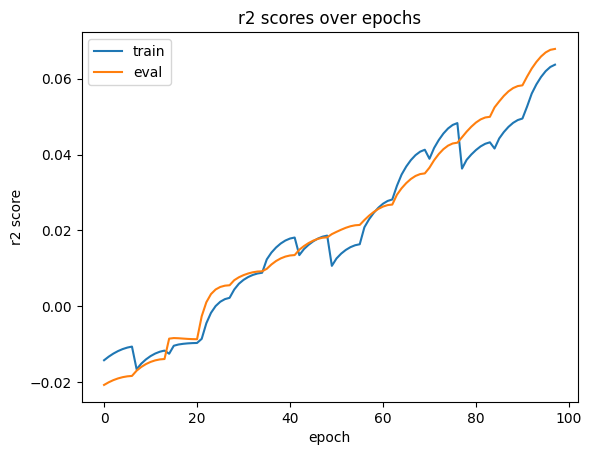

In [14]:
plt.plot(train_r2_scores, label="train")
plt.plot(eval_r2_scores, label="eval")
plt.xlabel("epoch")
plt.ylabel("r2 score")
plt.title("r2 scores over epochs")
plt.legend()
plt.show()

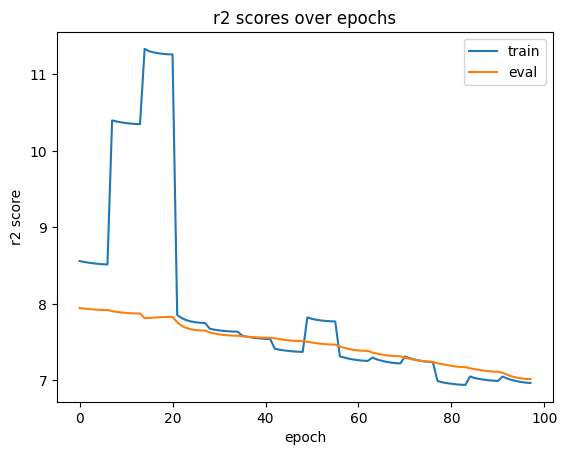

In [15]:
plt.plot(train_losses, label="train")
plt.plot(eval_losses, label="eval")
plt.xlabel("epoch")
plt.ylabel("r2 score")
plt.title("r2 scores over epochs")
plt.legend()
plt.show()